In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Generate date range
dates = pd.date_range(start='2022-01-01', end='2023-12-31', freq='D')

# Generate synthetic rainfall data (in mm)
# Assuming some seasonality: more rainfall in certain months
rainfall = (
    20 + 10 * np.sin(2 * np.pi * dates.dayofyear / 365) + 
    np.random.normal(0, 5, len(dates))
)
rainfall = np.clip(rainfall, 0, None)  # Rainfall can't be negative

# Generate synthetic visitor numbers
# Assume visitors decrease with more rainfall
base_visitors = 200 + 20 * np.sin(2 * np.pi * dates.dayofyear / 365)
visitor_numbers = base_visitors - 5 * rainfall 
visitor_numbers = np.clip(visitor_numbers, 0, None).astype(int)

# Create DataFrame
data = pd.DataFrame({
    'Date': dates,
    'Rainfall_mm': rainfall,
    'Visitor_Numbers': visitor_numbers
})

# Set Date as index
data.set_index('Date', inplace=True)

# Display first few rows
print(data.head())


            Rainfall_mm  Visitor_Numbers
Date                                    
2022-01-01    22.655704               87
2022-01-02    19.652895              102
2022-01-03    23.754639               82
2022-01-04    28.303174               59
2022-01-05    19.688881              103


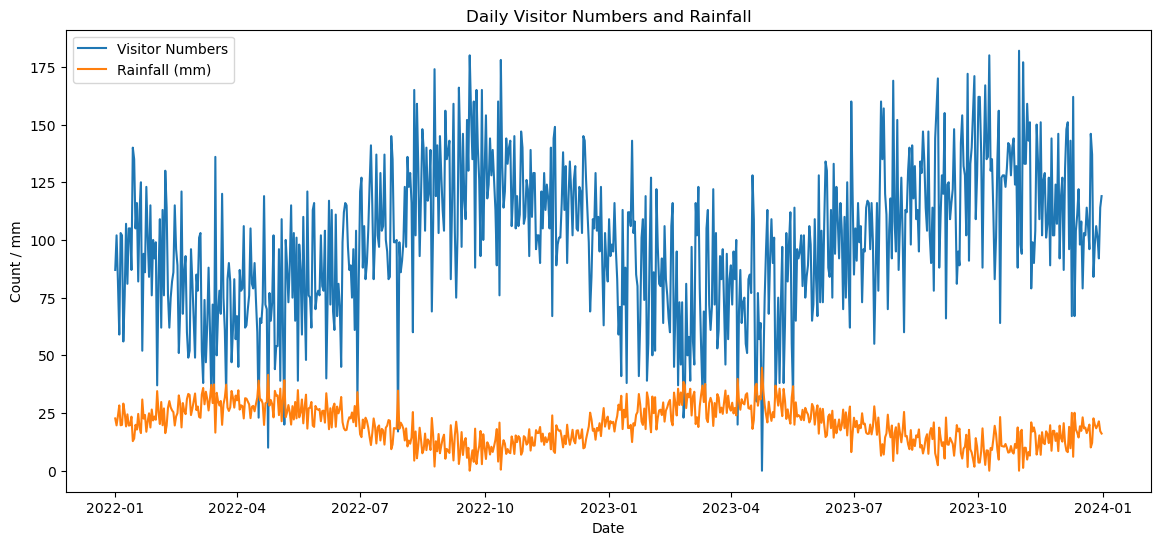

In [10]:
plt.figure(figsize=(14,6))
plt.plot(data.index, data['Visitor_Numbers'], label='Visitor Numbers')
plt.plot(data.index, data['Rainfall_mm'], label='Rainfall (mm)')
plt.title('Daily Visitor Numbers and Rainfall')
plt.xlabel('Date')
plt.ylabel('Count / mm')
plt.legend()
plt.show()


In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

# 1. Generate Sample Dataset (if not already done)
np.random.seed(42)
dates = pd.date_range(start='2022-01-01', end='2023-12-31', freq='D')
rainfall = (
    20 + 10 * np.sin(2 * np.pi * dates.dayofyear / 365) + 
    np.random.normal(0, 5, len(dates))
)
rainfall = np.clip(rainfall, 0, None)
base_visitors = 200 + 20 * np.sin(2 * np.pi * dates.dayofyear / 365)
visitor_numbers = base_visitors - 5 * rainfall 
visitor_numbers = np.clip(visitor_numbers, 0, None).astype(int)
data = pd.DataFrame({
    'Date': dates,
    'Rainfall_mm': rainfall,
    'Visitor_Numbers': visitor_numbers
})
data.set_index('Date', inplace=True)

# 2. Data Preprocessing
features = data[['Rainfall_mm']].values  # Shape: (num_samples, 1)
target = data['Visitor_Numbers'].values.reshape(-1, 1)  # Shape: (num_samples, 1)

# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit scalers on the entire dataset
scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target)

# Define sequence length
sequence_length = 30  # Using past 30 days to predict the next day

# Function to create sequences
def create_sequences(features, target, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(features)):
        X.append(features[i-seq_length:i])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(scaled_features, scaled_target, sequence_length)

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f'Training samples: {X_train.shape[0]}')
print(f'Testing samples: {X_test.shape[0]}')

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Create PyTorch Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Dataset instances
train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
test_dataset = TimeSeriesDataset(X_test_tensor, y_test_tensor)

# Create DataLoader instances
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Training samples: 560
Testing samples: 140


In [12]:
import torch
import torch.nn as nn

class LSTMForecastModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, dropout=0.2, output_size=1):
        super(LSTMForecastModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: batch_size, seq_length, hidden_size
        
        # Take the output from the last time step
        out = out[:, -1, :]  # batch_size, hidden_size
        
        # Apply dropout
        out = self.dropout(out)
        
        # Pass through the fully connected layer
        out = self.fc(out)  # batch_size, output_size
        
        return out


In [13]:
import torch.optim as optim

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Instantiate the model
model = LSTMForecastModel(input_size=1, hidden_size=50, num_layers=1, dropout=0.2, output_size=1)
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)  # Shape: (batch_size, seq_length, input_size)
        y_batch = y_batch.to(device)  # Shape: (batch_size, output_size)
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * X_batch.size(0)
    
    epoch_loss /= len(train_loader.dataset)
    
    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item() * X_val.size(0)
    val_loss /= len(test_loader.dataset)
    
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')


Using device: cuda
Epoch [1/50], Training Loss: 0.1135, Validation Loss: 0.0708
Epoch [10/50], Training Loss: 0.0210, Validation Loss: 0.0194
Epoch [20/50], Training Loss: 0.0208, Validation Loss: 0.0192
Epoch [30/50], Training Loss: 0.0203, Validation Loss: 0.0199
Epoch [40/50], Training Loss: 0.0197, Validation Loss: 0.0202
Epoch [50/50], Training Loss: 0.0200, Validation Loss: 0.0202


In [14]:
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Concatenate all batches
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# Inverse transform to get original scale
predictions_inv = target_scaler.inverse_transform(predictions)
actuals_inv = target_scaler.inverse_transform(actuals)

# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actuals_inv, predictions_inv)
mae = mean_absolute_error(actuals_inv, predictions_inv)
print(f'Test MSE: {mse:.2f}')
print(f'Test MAE: {mae:.2f}')


Test MSE: 669.67
Test MAE: 20.92


In [17]:
# Number of days to forecast
forecast_days = 365

# Generate future rainfall data (similar to earlier)
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='D')
future_rainfall = (
    20 + 10 * np.sin(2 * np.pi * future_dates.dayofyear / 365) + 
    np.random.normal(0, 5, len(future_dates))
)
future_rainfall = np.clip(future_rainfall, 0, None)

# Scale future rainfall
scaled_future_rainfall = feature_scaler.transform(future_rainfall.values.reshape(-1, 1))


# Initialize input sequence with the last 'sequence_length' rainfall data from training set
current_sequence = scaled_features[-sequence_length:].tolist()  # list of lists

predictions_future = []

model.eval()
with torch.no_grad():
    for rainfall in scaled_future_rainfall:
        # Prepare input
        input_seq = torch.tensor(current_sequence, dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, seq_length, 1)
        
        # Predict
        pred_scaled = model(input_seq)
        pred = target_scaler.inverse_transform(pred_scaled.cpu().numpy())[0][0]
        predictions_future.append(pred)
        
        # Append the current rainfall to the sequence and remove the first element
        current_sequence.append([rainfall[0]])
        current_sequence.pop(0)

# Create a DataFrame for future predictions
prediction_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Visitor_Numbers': predictions_future,
    'Predicted_Visitor_Numbers': predictions_future,
    'Rainfall_mm': future_rainfall
})
prediction_df.set_index('Date', inplace=True)

# Display predictions
print(prediction_df.head())


            Predicted_Visitor_Numbers  Rainfall_mm
Date                                              
2024-01-01                  99.916985    17.293944
2024-01-02                 100.003227    20.954265
2024-01-03                  99.571152    33.316619
2024-01-04                  96.826126    20.207725
2024-01-05                  95.418159    26.606015


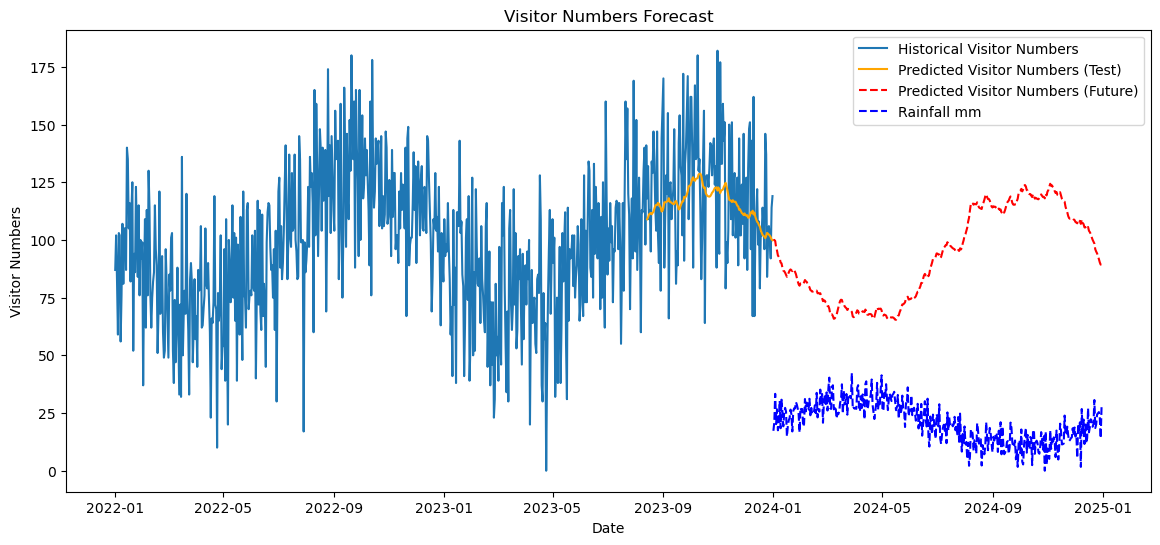

In [19]:
import matplotlib.pyplot as plt

# Plot historical visitor numbers
plt.figure(figsize=(14,6))
plt.plot(data.index, data['Visitor_Numbers'], label='Historical Visitor Numbers')

# Plot predicted visitor numbers on test set
plt.plot(data.index[-len(predictions_inv):], predictions_inv, label='Predicted Visitor Numbers (Test)', color='orange')

# Plot future predictions
plt.plot(prediction_df.index, prediction_df['Predicted_Visitor_Numbers'], 
         label='Predicted Visitor Numbers (Future)', color='red', linestyle='--')

# Plot future rainfall
plt.plot(prediction_df.index, prediction_df['Rainfall_mm'], color='blue', label='Rainfall mm', linestyle='--')


plt.title('Visitor Numbers Forecast')
plt.xlabel('Date')
plt.ylabel('Visitor Numbers')
plt.legend()
plt.show()
